In [1]:
import numpy as np
import scipy as sp
from scipy.stats import gamma, multivariate_normal
import matplotlib.pylab as plt
import sys, os

random patchesの生成

In [2]:
# Produces a matrix whose columns are a set of discreete fourier base vectors        
def get_fourier_base(m):
    base = np.empty([m,m])
    L = 2*np.pi/(1.0*m)
    
    for i in range(m):
        f = i//2
        if (i%2 == 0):
            for j in range(m):
                base[i, j] = np.cos(L*f*j)
        else:
            for j in range(m):
                base[i, j] = np.sin(L*f*j)
        norm = np.linalg.norm(base[j])
        if (norm != 0):
            base[j] = base[j]/norm
    return base.T

In [3]:
# Create an input covariance C with the right symmetry
# from the fourier base
def get_C_from_fourier(epsilon,base, decay_length):
    m = len(base)
    C = epsilon * np.identity(m) # Regularizer
    for i in range(m):
        v = base[:,i]
        lbda = 20*np.exp(-(1.0*(i//2))/decay_length)
        C = np.add(C,lbda*np.outer(v,v))
    C = C - 0.25    
    C =  C * (4.0/C[0,0])
    return C    

Get x from y and z

In [4]:
def get_x(y,z,A,s_x):
    x_mean = z*np.dot(A,y)
    noise = np.random.normal(scale=s_x, size=len(x_mean))
    return np.add(x_mean,noise)

Functions to compute mean and covariance of the posterior

In [5]:
def get_post_moments(x,z_MAP,s_x_2,A,ATA,C_inv):
    Sigma = get_Sigma_z(z_MAP,s_x_2,C_inv,ATA)
    mu = get_mu_z(z_MAP,s_x_2,Sigma,A,x)
    return (mu, Sigma) 

In [6]:
def get_mu_z(z,s_x_2,Sigma_post,A,x):
    mu = (z/s_x_2)*np.dot(Sigma_post,np.dot(A.T,x))
    return mu 

In [7]:
def get_Sigma_z(z,s_x_2,C_inv,ATA):
    M = np.add(C_inv,(z*z/s_x_2)*ATA)
    return np.linalg.inv(M)

In [8]:
def get_post_moments_full_inference(x,p_z,s_x_2,A,ATA,C_inv):
    threshold = 10000.0
    dy = len(C_inv)
    n_points = len(p_z[0])
    mu_post = np.zeros(dy)
    Sigma_post = np.zeros((dy,dy))
    i_p_max = np.argmax(p_z[1])
    p_max = p_z[1,i_p_max]
    i_min = 0
    dz = p_z[0,1] - p_z[0,0]
    for i in range(i_p_max,-1,-1):
        if (p_z[1,i] <= (p_max/threshold)):
            i_min = i
            break
    i_max = n_points
    for i in range(i_p_max,n_points):
        if (p_z[1,i] <= (p_max/threshold)):
            i_max = i
            break
            
    for i in range(i_min,i_max):
        z = p_z[0,i]
        Sigma = get_Sigma_z(z,s_x_2,C_inv,ATA)
        mu = get_mu_z(z,s_x_2,Sigma,A,x)
        mu_post += (mu * p_z[1,i])
        # E[Var]_z + Var(mu)_z
        Sigma_post += ((Sigma + np.outer(mu,mu))* p_z[1,i])
    
    mu_post *= dz
    Sigma_post *= dz        
    # Substracting E(mu)E(mu)T
    Sigma_post -= np.outer(mu_post, mu_post)
    return (mu_post, Sigma_post) 

In [9]:
def log_P_z (z, k, theta):
    return sp.stats.gamma.logpdf(z, k, loc=0, scale=theta)

In [10]:
def P_z_giv_x (z_range,x,ACAT,s_x_2, k, theta):
    n_contrasts = len(z_range)
    D_x = len(x)
    log_p = np.empty([n_contrasts])
    mean = np.zeros([D_x])
    dz = z_range[1] - z_range[0]
    for i in range(n_contrasts):
        Cov = np.add(z_range[i]*z_range[i]*ACAT,s_x_2*np.identity(D_x))
        log_p[i] = log_P_z(z_range[i], k, theta) + multivariate_normal.logpdf(x, mean, Cov)
    
    max_lp = np.amax(log_p)
    p = np.exp(log_p-max_lp)
    norm = np.sum(p) * dz
    p = p/norm
    
    return p   

## Main

In [11]:
baseline = 3.0 # We add this to the means only in the targets folder
input_case = "sampled" # "bumps" #
np.random.seed(seed=912345678)

x_noise = False # True # If true we add noise to x
FILTER_FILE = "filters.npy"

In [12]:
# We first import the filters, since this determines the dimensionality
A = np.load(FILTER_FILE)
ATA = np.dot(A.T,A)


D_x = len(A)              # Dimensionality of the observed variable x
D_y = len(A[0])           # Dimensionality of the hidden variable y
L = int(np.sqrt(D_x))          # Side length of the square image represented by x

h_scale = 1.0/15.0

In [13]:
# We create the basis matrix B
B = get_fourier_base(D_y)

In [14]:
# We build C from B
decay_length = D_y / 50.0 # for the eigenvalues of C
epsilon = 0.01 # regularizer for C
C = get_C_from_fourier(epsilon,B, decay_length)

In [15]:
d = 0.0 * np.sqrt(C[0,0]) # average mean of y in units of sd's 

ACAT = np.dot(np.dot(A,C),A.T)

# We generate the dataset

n_targets = 6            # N° of points in the dataset (or total observation time)

# Dist params:
s_x = 10.0                # Noise of the x process
s_x_2 = s_x**2
k = 2.0                   # Shape parameter of the gamma dist. for z
theta = 2.0               # Scale parameter of the gamma dist. for z

# Mean and covariance of y:
y_mean = np.zeros(D_y)            # The mean is 0 for y

# We will need the inverse of C
C_inv = np.linalg.inv(C)

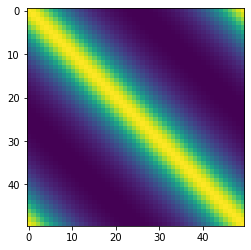

In [16]:
plt.imshow(C)

In [17]:
C.max(), C.min()

(3.9999999999999996, 1.8307496549983466)

In [18]:
x_array = np.empty([n_targets,D_x])

# Drawing samples for y and setting contrast levels (we fix those)
y_array = np.empty([n_targets,D_y])
#z_array = np.random.gamma(shape = k, scale=theta, size = n_targets)

#if input_case == "sampled": z_array = np.array([0.0,0.0,0.5,0.5,1.0,1.0])
z_array = np.array([0.0,0.125,0.25,0.5,1.0,2.0])
print(z_array)
#np.savetxt(results_location+"/z_array",z_array)

if input_case == "sampled":
    print("Sampling y")
    # P(y) = N(0, C)
    a = np.random.multivariate_normal(mean = y_mean + d, cov = C, size = 1) 
    for alpha in range(n_targets):
        y_array[alpha] = a

elif input_case == "bumps":
    center = D_y//2
    sigma = 0.15*D_y
    print("Creating y bumps")
    for i in range(D_y):
        y_array[0,i] = 6*np.exp(-0.5*((i-center)/sigma)**2.0)

    y_array[0] -= np.mean(y_array[0])
    y_array[0] *= (np.sqrt(C[0,0])/np.std(y_array[0]))
    y_array[0] += d
    for alpha in range(n_targets):
        y_array[alpha] = y_array[0] # same

else:
    print("Unknown input case!")
    sys.exit()

# We now get the x samples
if x_noise:
    print("Obtaining x from y (with noise)")
    for alpha in range(n_targets):
        x_array[alpha] = get_x(y_array[alpha],z_array[alpha],A,s_x)
else:
    print("Obtaining x from y (without noise)")
    for alpha in range(n_targets):
        x_array[alpha] = z_array[alpha]*np.dot(A,y_array[alpha])

scale = np.amax(np.abs(x_array))

[0.    0.125 0.25  0.5   1.    2.   ]
Sampling y
Obtaining x from y (without noise)


In [19]:
y_array.min()

-2.2166754652114693

In [20]:
y_array.max()

0.9104310714449012

In [21]:
# We compute the moments of the posteriors
"""
mu_post_array_true_z = np.empty([n_targets,D_y])
Sigma_post_array_true_z = np.empty([n_targets,D_y,D_y])
std_post_array_true_z = np.empty([n_targets,D_y])
"""

mu_post_array_z_MAP = np.empty([n_targets,D_y])
Sigma_post_array_z_MAP = np.empty([n_targets,D_y,D_y])
std_post_array_z_MAP = np.empty([n_targets,D_y])

"""
mu_post_array_full_inf = np.empty([n_targets,D_y])
Sigma_post_array_full_inf = np.empty([n_targets,D_y,D_y])
std_post_array_full_inf = np.empty([n_targets,D_y])
"""

z_min = 0.0
z_max = 5.0
n_points = 201
z_range = np.linspace(z_min, z_max, num=n_points, endpoint=True)

z_MAP_array = np.empty([n_targets])

print("Computing posterior moments")

for alpha in range(n_targets):
    print("Target "+str(alpha))
    p_z = P_z_giv_x(z_range,x_array[alpha],ACAT,s_x_2, k, theta)

    # Moments at MAP contrast
    z_MAP_array[alpha] = z_range[np.argmax(p_z)]
    mu_post_array_z_MAP[alpha],Sigma_post_array_z_MAP[alpha] = get_post_moments(
                                            x_array[alpha],z_MAP_array[alpha],s_x_2,A,ATA,C_inv)
    std_post_array_z_MAP[alpha] = np.sqrt(np.diag(Sigma_post_array_z_MAP[alpha]))

    # Full inference 
    """
    mu_post_array_full_inf[alpha],Sigma_post_array_full_inf[alpha] = get_post_moments_full_inference(x_array[alpha],p_z,s_x_2,A,ATA,C_inv)

    std_post_array_full_inf[alpha] = np.sqrt(np.diag(Sigma_post_array_full_inf[alpha]))
    """

Computing posterior moments
Target 0
Target 1
Target 2
Target 3
Target 4
Target 5


## 結果
#### 入力

`z_array`が入力作成時に使われたもの．

In [22]:
x_min, x_max = x_array.min(), x_array.max()

In [23]:
x_min, x_max 

(-9.879111047013556, 8.642512335895368)

In [24]:
np.save("x_array.npy", x_array)

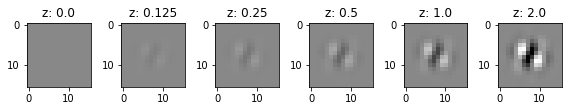

In [25]:
plt.figure(figsize=(8,2))
for alpha in range(n_targets):
    plt.subplot(1, n_targets ,alpha+1)
    plt.title("z: "+str(z_array[alpha]))
    plt.imshow(x_array[alpha].reshape(16, 16), 
               vmin=x_min, vmax=x_max, cmap="gray")
plt.tight_layout()

#### mu, std

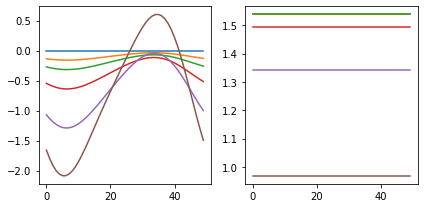

In [26]:
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
for i in range(n_targets):
    plt.plot(mu_post_array_z_MAP[i])

plt.subplot(1,2,2)
for i in range(n_targets):
    plt.plot(std_post_array_z_MAP[i])
plt.tight_layout()

#### Sigma

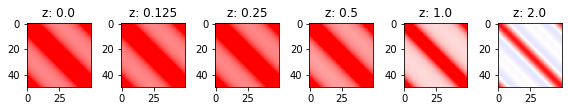

In [27]:
plt.figure(figsize=(8,2))
for alpha in range(n_targets):
    plt.subplot(1,n_targets,alpha+1)
    plt.title("z: "+str(z_array[alpha]))
    plt.imshow(Sigma_post_array_z_MAP[alpha],
               vmin=-1, vmax=1,cmap="bwr")
plt.tight_layout()

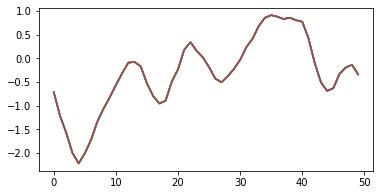

In [28]:
plt.figure(figsize=(6,3))
for i in range(n_targets):
    plt.plot(y_array[i])

### output

In [29]:
"""
uTh = 1.9
thGam = 2
sigmaX = 0.7945
m = 10
alpha = 1.4
beta = 1.1
"""

'\nuTh = 1.9\nthGam = 2\nsigmaX = 0.7945\nm = 10\nalpha = 1.4\nbeta = 1.1\n'

In [30]:
def membrane_potential(y, alpha=1.4):
    return np.sign(y)*np.abs(y)**alpha

In [31]:
def firing_rate(u, beta=1.1, m=10, uTh=1.9):
    return m*np.maximum(0, u-uTh)**beta

In [32]:
nt = 500
u_list = []
for alpha in range(n_targets):
    mu = mu_post_array_z_MAP[alpha]
    Sigma = Sigma_post_array_z_MAP[alpha]
    sample = np.random.multivariate_normal(mean=mu, cov=Sigma, size=nt)
    u = membrane_potential(sample)
    u_list.append(u)

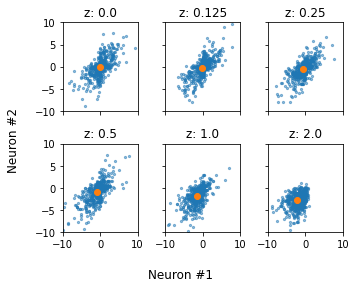

In [33]:
fig, ax = plt.subplots(2, 3, figsize=(5, 4), sharex="all", sharey="all")#, dpi=300)
for i in range(2):
    for j in range(3):
        alpha = i*3 + j
        u = u_list[alpha]
        ax[i, j].set_title("z: "+str(z_array[alpha]))
        ax[i, j].scatter(u[:, 0], u[:, 5], alpha=0.5, s=5)
        ax[i, j].scatter(u[:, 0].mean(), u[:, 5].mean())
        ax[i, j].set_xlim(-10,10)
        ax[i, j].set_ylim(-10,10)
fig.supxlabel("Neuron #1")
fig.supylabel("Neuron #2")
plt.tight_layout()